## Housekeeping Settings

In [1]:
# env_path = /ocean/projects/cis240075p/asachan/.conda/envs/env_stream/bin/python

In [2]:
import numpy as np, pandas as pd, scanpy as sc, anndata as ad, matplotlib.pyplot as plt, os, seaborn as sns, stream as st
wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell1/male_donor/'
out_path = os.path.join(wd, 'out_data', 'sc_preproc')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
sc.settings.figdir = f"{out_path}/figures"

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
#set the imputed gene expression as the accessible data layer
adata = st.read(f'{out_path}/out_files/stream_input_filtered_cells.h5ad', workdir=f"{out_path}/out_files")
st.set_workdir(adata,f"{out_path}/out_files")
adata.X = adata.layers['MAGIC_imputed_data']

Saving results in: /ocean/projects/cis240075p/skeshari/igvf/bcell1/male_donor/out_data/sc_preproc/out_files
Saving results in: /ocean/projects/cis240075p/skeshari/igvf/bcell1/male_donor/out_data/sc_preproc/out_files


# Run stream dim reduction (LLE) on the anndata, with imputed gene expression and filtered cells

829 variable genes are selected


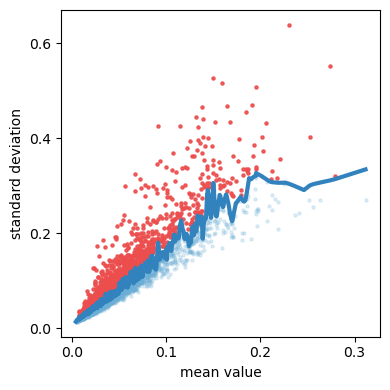

In [4]:
st.select_variable_genes(adata,loess_frac=0.005, percentile=80)

In [5]:
# 'var_genes' vs 'all' : use top % or all genes from .var ; if using all make sure the adata is subsetted to only the highly variable genes
st.dimension_reduction(adata,method='mlle',feature='var_genes',n_components=2,n_neighbors=30,n_jobs=64) # using the same knn as diffusion maps (default is 30)

feature var_genes is being used ...
64 cpus are being used ...


Saving results in: /tmp/tmpnxxc2fn5
Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 3
Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 28494 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||50
	
1.246e-06
	
50
	
49
	
46
	
1
	
0
	
0
	
4.387e-07
	
4.048e-07
	
0.9937
	
0.9942
	
7.425e-07
	
6.49e-08
	
3.245e-06
	
0.0001623
	
0




/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


75.343 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 3
Extending leaves with additional nodes ...
Number of branches after extending leaves: 3
Optimizing branching...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 83 nodes on 28494 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
53
 
54
 
55
 
56
 
57
 
58
 
59
 
60
 
61
 
62
 
63
 
64
 
65
 
66
 
67
 
68
 
69
 
70
 
71
 
72
 
73
 
74
 
75
 
76
 
77
 
78
 
79
 
80
 
81
 
82
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||83
	
8.937e-07
	
83
	
82
	
79
	
1
	
0
	
0
	
3.175e-07
	
3.002e-07
	
0.9955
	
0.9957
	
5.418e-07
	
3.442e-08
	
2.857e-06
	
0.0002371
	
0


10.142 sec elapsed

Number of branches after optimizing branching: 3
Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


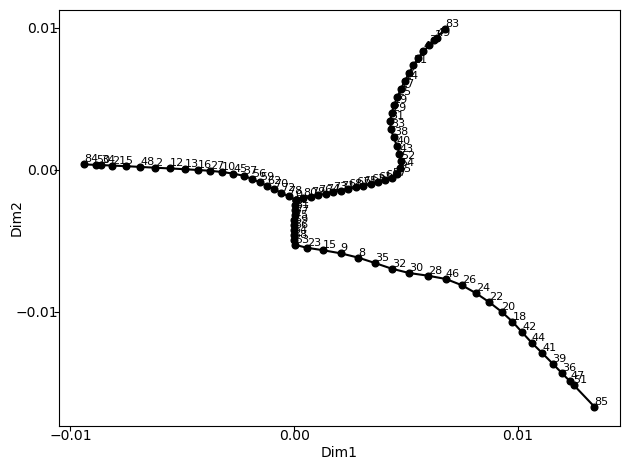

In [6]:
import os
os.environ["OMP_NUM_THREADS"] = "64"
from tempfile import TemporaryDirectory
from rpy2.robjects import r
# Load the rlang package in R
r('library(rlang)')

# Parameters for STREAM (tune to your dataset)
ka1={'epg_alpha':0.02,'epg_mu':0.07,'epg_lambda':0.02,'epg_trimmingradius':2} # epg_mu needs to be tuned to get a good branch for day-1 to activated and undefined cells
ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}

# Trajectory inference
with TemporaryDirectory() as td:
	st.set_workdir(adata,td)
	st.seed_elastic_principal_graph(adata,n_clusters=10)
	st.elastic_principal_graph(adata,**ka1)
	st.extend_elastic_principal_graph(adata,**ka2)

st.optimize_branching(adata,incr_n_nodes=30) #smoothen out the branches
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
st.plot_branches(adata,show_text=True)

In [7]:
leiden_color_dict = {
       '0': 'lightskyblue',
        '1': 'dodgerblue',
        '2': 'mediumorchid',
        '3': 'limegreen',
        '4': 'darkblue',
        '5': 'darkgray',
        '6': 'green',
        '7': 'firebrick',
        '8': 'sandybrown',
        '9': 'lightcoral',
        '10': 'teal'
}

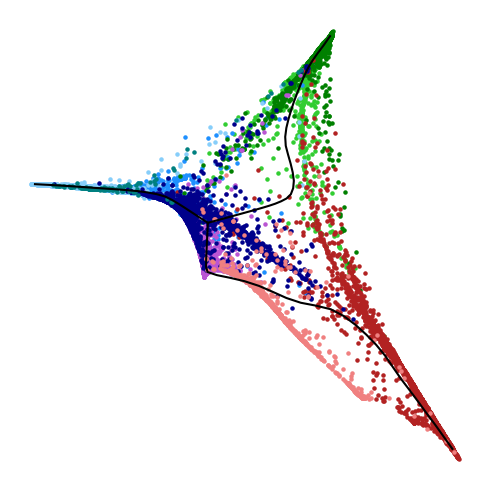

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring
labels = adata.obs['leiden']

# Get unique labels and their corresponding colors
unique_labels = labels.unique()
color_list = [ leiden_color_dict[label] for label in unique_labels]

fig = plt.figure(figsize=(5,5))
ax_i = fig.add_subplot()

comp1, comp2 = 0, 1
key_graph = 'epg'

if key_graph == 'epg':
    epg = adata.uns['epg']
    flat_tree = adata.uns['flat_tree']
else:
    epg = adata.uns[key_graph.split('_')[0]+'_epg']
    flat_tree = adata.uns[key_graph.split('_')[0]+'_flat_tree']

ft_node_pos = nx.get_node_attributes(flat_tree, 'pos')
ft_node_label = nx.get_node_attributes(flat_tree, 'label')
epg_node_pos = nx.get_node_attributes(epg, 'pos')

for edge_i in flat_tree.edges():
    branch_i_pos = np.array([epg_node_pos[i] for i in flat_tree.edges[edge_i]['nodes']])
    curve_i = pd.DataFrame(branch_i_pos, columns=np.arange(branch_i_pos.shape[1]))
    ax_i.plot(curve_i[comp1], curve_i[comp2], c='black', zorder=5)

for label, color in zip(unique_labels, color_list):
    idx = labels == label
    ax_i.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=color, label=label, s=5)

# Remove ticks
ax_i.set_xticks([])
ax_i.set_yticks([])

# Remove top and right spines
ax_i.spines['top'].set_visible(False)
ax_i.spines['right'].set_visible(False)
ax_i.spines['bottom'].set_visible(False)
ax_i.spines['left'].set_visible(False)

# Adjust layout
fig.tight_layout()
plt.savefig(f'{out_path}/figures/traj_with_leiden_colors.pdf',
            bbox_inches='tight',  # Ensures the legend isn't cut off
            dpi=600,             # High resolution
            format='pdf')
plt.tight_layout()


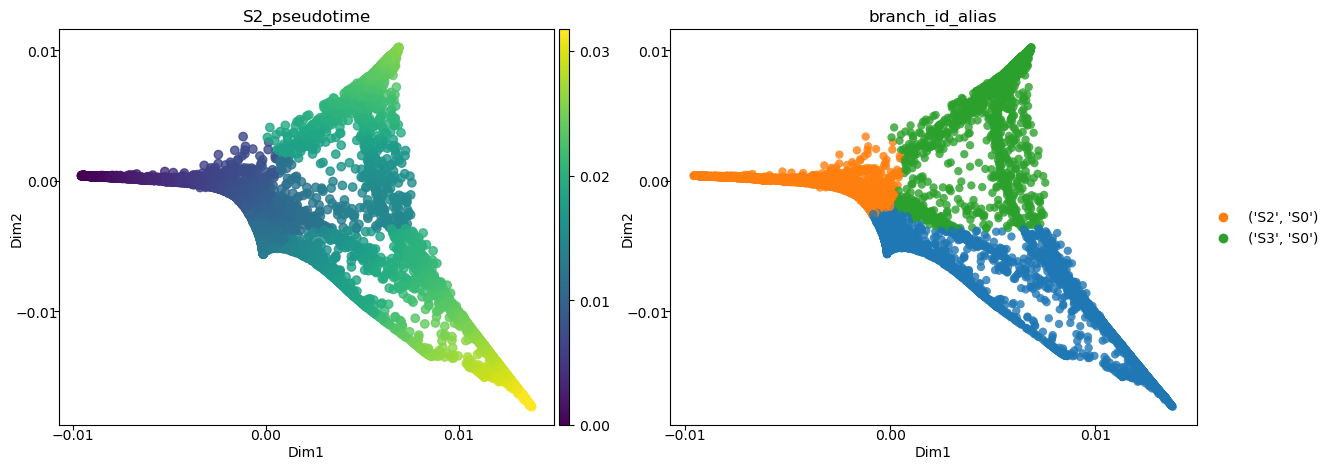

In [9]:
st.plot_dimension_reduction(adata,color=['S2_pseudotime','branch_id_alias'])

In [10]:
stream_xdr = pd.DataFrame(adata.obsm['X_dr'], columns=['x', 'y'])
stream_xdr.index = adata.obs_names
stream_xdr['leiden'] = adata.obs['leiden']
stream_xdr['S2_pseudotime'] = adata.obs['S2_pseudotime']
stream_xdr.to_csv(f'{out_path}/out_files/stream_xdr.csv')